<a href="https://colab.research.google.com/github/DeanHazineh/Pytorch-Deep-Learning-Examples/blob/main/GPT2_Text_Completion_with_Speculative_Sampling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and load the huggingface transformer sub-modules

Here, we are going to be using the small model ("GPT2") and the large model ("GPT2-Large"), which have approximately 124M and 774M parameters, respectively. For reference, other versions include "-medium" and "-XL". 

In [ ]:
import torch 
import torch.nn as nn
from torch.nn import functional as F

device = "cuda:0" if torch.cuda.is_available() else "cpu" 
device = torch.device(device) 
print("torch device: ", device)

import matplotlib.pyplot as plt
import numpy as np
import random
import copy
import time


torch device:  cuda:0


In [ ]:
# Install the huggingface gpt folder
!pip install transformers
from transformers import GPT2Tokenizer, GPT2Model, GPT2LMHeadModel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 23.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 3.5 MB/s eta 0:00:00


In [ ]:
# Load the two models and move to GPU
tokenizerL = GPT2Tokenizer.from_pretrained('gpt2-large')
modelL = GPT2LMHeadModel.from_pretrained('gpt2-large').to(device)

tokenizerS = GPT2Tokenizer.from_pretrained("gpt2")
modelS = GPT2LMHeadModel.from_pretrained("gpt2").to(device)

# model.logits returns prediction scores of the language modeling head (scores for each vocabulary token before SoftMax).
softmax_layer = nn.Softmax(dim=2).to(device)

First, we will run some basic demos of huggingface GPT to get some intuition about the outputs

In [ ]:
torch.manual_seed(23)
random.seed(23)

# Choose the demo model of either the above large or small
model = modelL
tokenizer = tokenizerL

# Print for reference the vocab size
vocab_size = tokenizer.vocab_size
print(f"vocab size for gpt2: {vocab_size} \n")

# Do a simple demo (encode-and-decode)
print("Basic encode_decode_test")
text = "this is a text string"
encoded_ids = tokenizer(text)["input_ids"]
decoded_text = tokenizer.decode(encoded_ids)
print(f"Input text: {text}\n Encoded Ids: {encoded_ids}\n Decoded Text: {decoded_text}\n")

# Run a simple next-word prediction demo 
print("Next Token Prediction Test from single call batch")
input_txt = "it was the best of times, it was the worst"
input_token = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_pred_dist = softmax_layer(model(input_token).logits) # [batch, len, vocab_size]
draw_ids = torch.argmax(output_pred_dist, dim=(2))[0]
for i in range(input_token.shape[1]):
  next_word = tokenizer.decode(draw_ids[i])
  in_seq = tokenizer.decode(input_token[0,:i+1], )
  print(f"sequence: '{in_seq}' | next word: '{next_word}' \n")


vocab size for gpt2: 50257 

Basic encode_decode_test
Input text: this is a text string
 Encoded Ids: [5661, 318, 257, 2420, 4731]
 Decoded Text: this is a text string

Next Token Prediction Test from single call batch
sequence: 'it' | next word: ''s' 

sequence: 'it was' | next word: ' a' 

sequence: 'it was the' | next word: ' first' 

sequence: 'it was the best' | next word: ' thing' 

sequence: 'it was the best of' | next word: ' times' 

sequence: 'it was the best of times' | next word: ',' 

sequence: 'it was the best of times,' | next word: ' it' 

sequence: 'it was the best of times, it' | next word: ' was' 

sequence: 'it was the best of times, it was' | next word: ' the' 

sequence: 'it was the best of times, it was the' | next word: ' worst' 

sequence: 'it was the best of times, it was the worst' | next word: ' of' 



# Speculative Sampling

The principle of speculative sampling was introduced in a recent work by DeepMind (https://arxiv.org/abs/2302.01318) and concurrently in (https://arxiv.org/abs/2302.01318). 

First, we create a function which implements the standard autoregressive text generation and the speculative sampling text generation model. Here we will run some test cases and verify the output. The model is statistical and so the runtimes in the cases below will change if reran. In the next section, we will look at averaged runtimes.

In [ ]:
def autoregressive_GPT(init_text, n_total_tokens, model_size="large", max_draw=False):
  model = modelL if model_size=="large" else modelS
  tokenizer = tokenizerL if model_size=="large" else tokenizerS

  # Generate next word sequentially
  start_time = time.time()

  n_tokens = len(tokenizer(init_text)["input_ids"])
  while n_tokens < n_total_tokens:
    input_token = tokenizer(init_text, return_tensors="pt")["input_ids"].to(device)
    output_pred_dist = softmax_layer(model(input_token).logits) # [batch, len, vocab_size]  
    next_id = torch.argmax(output_pred_dist[:, -1, :], dim=(1), keepdim=True) if max_draw else torch.multinomial(output_pred_dist[:,-1,:],1)
    next_word = tokenizer.decode(next_id[0])
    init_text = init_text+next_word
    #sequence = torch.cat((input_token, next_id), dim=1)
    #init_text = tokenizerL.decode(sequence[0,:], skip_special_tokens=True, clean_up_tokenization_spaces=True)
    n_tokens = n_tokens+1

  end_time = time.time()
  return init_text, end_time-start_time

def autoregressive_GPTL_speculative_sampling(init_text, n_total_tokens, k_next_tokens, debug=False):
  """
  Pass in an initial text string. Generate continuation of text n_total_tokens long. The rejection-based speculative sampling is computed with k_next_tokens small look-ahead.
  Args:
  init_text (string): User passed in text
  n_total_tokens (int): Length of the continaution text returned, in token length
  k_next_tokens (int): Parameter for the speculative sampling model. Number of tokens to pre-generate with the small model
  """
  t_tokens = len(tokenizerS(init_text)["input_ids"])
  if debug: print("init text: ", init_text, "| number tokens: ", t_tokens, "\n")
  start_time = time.time()

  fast_text = copy.copy(init_text)
  input_token_ids = tokenizerS(fast_text, return_tensors="pt")["input_ids"].to(device)
  while t_tokens < n_total_tokens:

    # Generate fast model predictions for k next tokens
    small_pred_prob = []
    for i in range(k_next_tokens):
      output_pred_dist = softmax_layer(modelS(input_token_ids).logits) # [batch, len, vocab_size]  
      small_pred_prob.append(output_pred_dist[:,-1,:])
      input_token_ids = torch.cat((input_token_ids, torch.multinomial(output_pred_dist[:,-1,:],1)), dim=1)
    small_pred_prob = torch.transpose(torch.stack(small_pred_prob), 1, 0)
    
    if debug:
      fast_text = tokenizerS.decode(input_token_ids[0,:])
      print(f"fast text: {fast_text}")

    # Use the big model to compute provisional tokens in parallel
    big_pred_prob = softmax_layer(modelL(input_token_ids).logits)[:, t_tokens-1:, :] # [batch, len, vocab_size]  
 
    # Run the rejection sampling algorithm
    udraw = np.random.uniform(size=(1,k_next_tokens))
    vocab_size = tokenizerS.vocab_size
    zeros_torch = torch.zeros((vocab_size)).to(device)
    final_gen_token = []
    for i in range(k_next_tokens):
      fast_sampled_tokenID = input_token_ids[0,t_tokens+i]
      ratio = big_pred_prob[0, i, fast_sampled_tokenID] / small_pred_prob[0,i,fast_sampled_tokenID]
      if udraw[0,i] > ratio: # repredict and break 
        newdist = torch.maximum(zeros_torch, big_pred_prob[0, i, :] - small_pred_prob[0, i, :])
        final_gen_token.append(torch.multinomial(newdist / torch.sum(newdist), 1)[0])
        break
      else: # Keep the fast prediction
        final_gen_token.append(fast_sampled_tokenID)

    # If we keep all k fast tokens, generate a new token from pbig
    if len(final_gen_token) == k_next_tokens:
      final_gen_token.append(torch.multinomial(big_pred_prob[:,-1,:], 1)[0,0])

    # End Matter Updating (encode and decode because token number can change by merging text due to redundancy)
    final_gen_token = torch.stack(final_gen_token)
    token_seq = torch.cat((tokenizerS(init_text, return_tensors="pt")["input_ids"][0].to(device), final_gen_token))
    init_text = tokenizerS.decode(token_seq)
    
    fast_text = copy.copy(init_text)
    input_token_ids = tokenizerS(fast_text, return_tensors="pt")["input_ids"].to(device)
    t_tokens = input_token_ids.shape[1]

    if debug:
      print(f"final text: {fast_text}")
      print(f"\n new token length {t_tokens}")

  end_time = time.time()
  return tokenizerS.decode(tokenizerS(init_text)["input_ids"][:n_total_tokens]), end_time - start_time

First we look at a very simple example. By viewing the speculative sampling output, we can see that we often get k or k+1 tokens from a single autoregressive run of the large model because the sequence is easy enough to be predicted by the small models.

In [ ]:
init_text = "A B C D"

# gptL_out, runtimeL = autoregressive_GPT(init_text, 25, model_size="large")
# gptS_out, runtimeS = autoregressive_GPT(init_text, 25, model_size="small")

print(f"GPTL | time: {runtimeL} Text: {gptL_out} \n")
print(f"GPTS | time: {runtimeS} Text: {gptS_out} \n")

print("Run the speculative sampling in debug mode:")
spec_text, spec_runtime = autoregressive_GPTL_speculative_sampling(init_text, n_total_tokens=25 , k_next_tokens=5, debug=True)
print(f"SpecGPTL | time: {spec_runtime} Text: {spec_text}")

GPTL | time: 1.946852684020996 Text: A B C D E F G H I J K L M N O P Q R S T U V W X Y 

GPTS | time: 0.5140266418457031 Text: A B C D E F G H I J K L M N O P Q R S T U V W X Y 

Run the speculative sampling in debug mode:
init text:  A B C D | number tokens:  4 

fast text: A B C D E F G H I
final text: A B C D E F G H I J

 new token length 10
fast text: A B C D E F G H I J K L M N O
final text: A B C D E F G H I J K L M N O P

 new token length 16
fast text: A B C D E F G H I J K L M N O P Q R S T U
final text: A B C D E F G H I J K L M N O P Q R S T U V

 new token length 22
fast text: A B C D E F G H I J K L M N O P Q R S T U V W X Y Z AL
final text: A B C D E F G H I J K L M N O P Q R S T U V W X Y Z AAAM

 new token length 28
SpecGPTL | time: 0.5783092975616455 Text: A B C D E F G H I J K L M N O P Q R S T U V W X Y


In [ ]:
repeat = 30
runtimeL = np.mean([autoregressive_GPT(init_text, 25, model_size="large")[1] for i in range(repeat)])
runtimeS = np.mean([autoregressive_GPT(init_text, 25, model_size="small")[1] for i in range(repeat)])
spec_runtime = np.mean([autoregressive_GPTL_speculative_sampling(init_text, n_total_tokens=25 , k_next_tokens=5, debug=False)[1] for i in range(repeat)])

print(f"GPTL: {runtimeL} GPTS: {runtimeS} GPTL_Spec: {spec_runtime}")
print(spec_runtime/runtimeL)

GPTL: 1.0482834974924724 GPTS: 0.36068517367045083 GPTL_Spec: 0.6374770482381185
0.608115123211406


We now try another test example that is less obvious than the alphabet string

In [ ]:
init_text = "It was the best of times, it was the worst"

gptL_out, runtimeL = autoregressive_GPT(init_text, 40, model_size="large")
gptS_out, runtimeS = autoregressive_GPT(init_text, 40, model_size="small")

print(f"GPTL | time: {runtimeL} Text: {gptL_out} \n")
print(f"GPTS | time: {runtimeS} Text: {gptS_out} \n")

print("Run the speculative sampling in debug mode:")
spec_text, spec_runtime = autoregressive_GPTL_speculative_sampling(init_text, n_total_tokens=40 , k_next_tokens=5, debug=True)
print(f"SpecGPTL | time: {spec_runtime} Text: {spec_text}")

GPTL | time: 1.4081530570983887 Text: It was the best of times, it was the worst of times," said Cristián Molina, secretary general of the union, which marched for the vote with its presidential candidate, José Manuel Bar 

GPTS | time: 0.4656803607940674 Text: It was the best of times, it was the worst. The Star Wars anybody could do it run 19 years, and it was really because of Wil Wheaton and the people who loved Star Wars. 

Run the speculative sampling in debug mode:
init text:  It was the best of times, it was the worst | number tokens:  11 

fast text: It was the best of times, it was the worst of times, he knows
final text: It was the best of times, it was the worst of times, it

 new token length 15
fast text: It was the best of times, it was the worst of times, it was the best of times
final text: It was the best of times, it was the worst of times, it was the age

 new token length 18
fast text: It was the best of times, it was the worst of times, it was the age of God and s

In [ ]:
repeat = 30
runtimeL = np.mean([autoregressive_GPT(init_text, 25, model_size="large")[1] for i in range(repeat)])
runtimeS = np.mean([autoregressive_GPT(init_text, 25, model_size="small")[1] for i in range(repeat)])
spec_runtime = np.mean([autoregressive_GPTL_speculative_sampling(init_text, n_total_tokens=25 , k_next_tokens=5, debug=False)[1] for i in range(repeat)])

print(f"GPTL: {runtimeL} GPTS: {runtimeS} GPTL_Spec: {spec_runtime}")
print(spec_runtime/runtimeL)

GPTL: 0.7268918832143147 GPTS: 0.2667467435201009 GPTL_Spec: 0.7000492254892985
0.9630720078943267


# Compute average runtimes on text dataset


Rather than repeat on the same sequence, let us consider taking the average over different starting text excerpts pulled from a text file. Since it is easy, we will use the shakespear text.

In [ ]:
import bs4
import sys
import requests

wiki_page = 'Harvard'
res = requests.get(f'https://en.wikipedia.org/wiki/{wiki_page}' )
res.raise_for_status()
wiki = bs4.BeautifulSoup(res.text,"html.parser")

# open a file named as your wiki page in write mode
with open(wiki_page+".txt", "w", encoding="utf-8") as f:
    for i in wiki.select('p'):
        # write each paragraph to the file
        f.write(i.getText())

In [ ]:
with open('Harvard.txt', 'r', encoding='utf-8') as f:
  data_text = f.read()
  token_text = tokenizerL(data_text)["input_ids"]
  max_num_tokens = len(token_text)

In [ ]:
def get_batch_tokens(batch_num, token_length):
  idx = np.random.randint(0, max_num_tokens - token_length, size=(batch_num))
  token_set = []
  for i in idx:
    token_set.append(token_text[i:i+token_length])
  return torch.tensor(token_set)

In [ ]:
random.seed(10)
torch.manual_seed(10)

num_batch = 10
n_total_tokens = 100 
k_lookahead = np.arange(2, 15, 1).astype(int) # Hyperparameter for the task
print(k_lookahead)
batch_tokens = get_batch_tokens(batch_num=num_batch,token_length=20)

hold_run_spec = np.zeros((len(k_lookahead), num_batch, 1))
hold_run_autoreg = np.zeros((1, num_batch, 2))

total_run = num_batch * len(k_lookahead)
counter = 0
for i in range(num_batch):  # Run the computation over different token batches
  init_text = tokenizerS.decode(batch_tokens[i,:])

  _, runtimeS = autoregressive_GPT(init_text, n_total_tokens, model_size="small")   # Compute small runtimes
  hold_run_autoreg[0, i, 0] = runtimeS

  _, runtimeL = autoregressive_GPT(init_text, n_total_tokens, model_size="large")  # compute large runtimes
  hold_run_autoreg[0, i, 1] = runtimeL

  for ki, k_next_tokens in enumerate(k_lookahead): # Compute speculative with different lookahead values
    # compute spec runtimes
    _, spec_runtime = autoregressive_GPTL_speculative_sampling(init_text, n_total_tokens=n_total_tokens , k_next_tokens=k_next_tokens)
    hold_run_spec[ki, i, 0] = spec_runtime 
    
    counter = counter+1
    print(f"Progress: {counter/total_run*100}" )


[ 2  3  4  5  6  7  8  9 10 11 12 13 14]
Progress: 0.7692307692307693
Progress: 1.5384615384615385
Progress: 2.307692307692308
Progress: 3.076923076923077
Progress: 3.8461538461538463
Progress: 4.615384615384616
Progress: 5.384615384615385
Progress: 6.153846153846154
Progress: 6.923076923076923
Progress: 7.6923076923076925
Progress: 8.461538461538462
Progress: 9.230769230769232
Progress: 10.0
Progress: 10.76923076923077
Progress: 11.538461538461538
Progress: 12.307692307692308
Progress: 13.076923076923078
Progress: 13.846153846153847
Progress: 14.615384615384617
Progress: 15.384615384615385
Progress: 16.153846153846153
Progress: 16.923076923076923
Progress: 17.692307692307693
Progress: 18.461538461538463
Progress: 19.230769230769234
Progress: 20.0
Progress: 20.76923076923077
Progress: 21.53846153846154
Progress: 22.30769230769231
Progress: 23.076923076923077
Progress: 23.846153846153847
Progress: 24.615384615384617
Progress: 25.384615384615383
Progress: 26.153846153846157
Progress: 26.

<ipython-input-155-e6a4df7d91d0>:5: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  ax.errorbar(k_lookahead, np.mean(hold_run_spec, axis=1), np.std(hold_run_spec, axis=1), label="Spec Sampling")


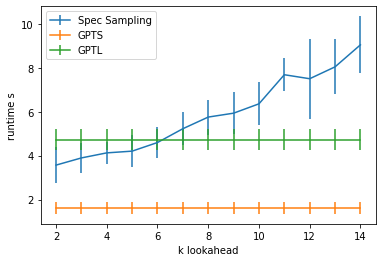

In [ ]:
autodat = np.tile(hold_run_autoreg, (len(k_lookahead), 1,1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(k_lookahead, np.mean(hold_run_spec, axis=1), np.std(hold_run_spec, axis=1), label="Spec Sampling")
ax.errorbar(k_lookahead, np.mean(autodat[:,:,0], axis=1), np.std(autodat[:,:,0], axis=1), label="GPTS")
ax.errorbar(k_lookahead, np.mean(autodat[:,:,1], axis=1), np.std(autodat[:,:,1], axis=1), label="GPTL")
ax.set_xlabel("k lookahead")
ax.set_ylabel("runtime s")
ax.legend()

This data set is much more difficult than the alphabet so we cannot get away with arbitrarily large look aheads. A small look ahead less than 6 presents a speedup relative to the standard autoregressive run!


In [ ]:
# We can repeat the same study but just using the init text "A B C D"
# In order to sweep k look-ahead values 

random.seed(10)
torch.manual_seed(10)

num_batch = 10
n_total_tokens = 100 
k_lookahead = np.arange(2, 15, 1).astype(int) # Hyperparameter for the task

hold_run_spec = np.zeros((len(k_lookahead), num_batch, 1))
hold_run_autoreg = np.zeros((1, num_batch, 2))
total_run = num_batch * len(k_lookahead)
counter = 0
for i in range(num_batch):  # Run the computation over different token batches
  init_text = "A B C D"

  _, runtimeS = autoregressive_GPT(init_text, n_total_tokens, model_size="small")   # Compute small runtimes
  hold_run_autoreg[0, i, 0] = runtimeS

  _, runtimeL = autoregressive_GPT(init_text, n_total_tokens, model_size="large")  # compute large runtimes
  hold_run_autoreg[0, i, 1] = runtimeL

  for ki, k_next_tokens in enumerate(k_lookahead): # Compute speculative with different lookahead values
    # compute spec runtimes
    _, spec_runtime = autoregressive_GPTL_speculative_sampling(init_text, n_total_tokens=n_total_tokens , k_next_tokens=k_next_tokens)
    hold_run_spec[ki, i, 0] = spec_runtime 
    
    counter = counter+1
    print(f"Progress: {counter/total_run*100}" )


Progress: 0.7692307692307693
Progress: 1.5384615384615385
Progress: 2.307692307692308
Progress: 3.076923076923077
Progress: 3.8461538461538463
Progress: 4.615384615384616
Progress: 5.384615384615385
Progress: 6.153846153846154
Progress: 6.923076923076923
Progress: 7.6923076923076925
Progress: 8.461538461538462
Progress: 9.230769230769232
Progress: 10.0
Progress: 10.76923076923077
Progress: 11.538461538461538
Progress: 12.307692307692308
Progress: 13.076923076923078
Progress: 13.846153846153847
Progress: 14.615384615384617
Progress: 15.384615384615385
Progress: 16.153846153846153
Progress: 16.923076923076923
Progress: 17.692307692307693
Progress: 18.461538461538463
Progress: 19.230769230769234
Progress: 20.0
Progress: 20.76923076923077
Progress: 21.53846153846154
Progress: 22.30769230769231
Progress: 23.076923076923077
Progress: 23.846153846153847
Progress: 24.615384615384617
Progress: 25.384615384615383
Progress: 26.153846153846157
Progress: 26.923076923076923
Progress: 27.692307692307

<ipython-input-159-e6a4df7d91d0>:5: MatplotlibDeprecationWarning: Support for passing a (n, 1)-shaped error array to errorbar() is deprecated since Matplotlib 3.1 and will be removed in 3.3; pass a 1D array instead.
  ax.errorbar(k_lookahead, np.mean(hold_run_spec, axis=1), np.std(hold_run_spec, axis=1), label="Spec Sampling")


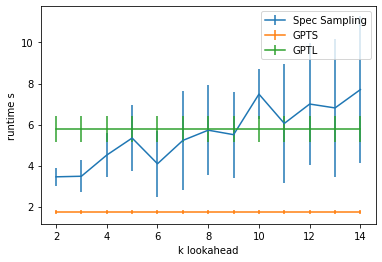

In [ ]:
autodat = np.tile(hold_run_autoreg, (len(k_lookahead), 1,1))

fig = plt.figure()
ax = fig.add_subplot(111)
ax.errorbar(k_lookahead, np.mean(hold_run_spec, axis=1), np.std(hold_run_spec, axis=1), label="Spec Sampling")
ax.errorbar(k_lookahead, np.mean(autodat[:,:,0], axis=1), np.std(autodat[:,:,0], axis=1), label="GPTS")
ax.errorbar(k_lookahead, np.mean(autodat[:,:,1], axis=1), np.std(autodat[:,:,1], axis=1), label="GPTL")
ax.set_xlabel("k lookahead")
ax.set_ylabel("runtime s")
ax.legend()